In [4]:
import numpy as np
from sklearn.decomposition import PCA
from Bio import Align
from Bio import SeqIO

# Load protein sequences
def load_protein_sequences(fasta_file):
    sequences = []
    labels = []

    for record in SeqIO.parse(fasta_file, "fasta"):
        sequence = str(record.seq)

        # Extract the class label from square brackets
        label_start = record.description.find("[") + 1
        label_end = record.description.find("]")

        if label_start != -1 and label_end != -1:
            label = int(record.description[label_start:label_end])
        else:
            label = None

        sequences.append(sequence)
        labels.append(label)

    return sequences, labels

# Calculate the Smith-Waterman similarity matrix using Align.PairwiseAligner
def calculate_similarity_matrix(sequences, aligner):
    num_sequences = len(sequences)
    similarity_matrix = np.zeros((num_sequences, num_sequences))

    for i in range(num_sequences):
        for j in range(i, num_sequences):
            alignment_score = aligner.score(sequences[i], sequences[j])
            similarity_matrix[i, j] = alignment_score
            similarity_matrix[j, i] = alignment_score  # Matrix is symmetric

    # Normalize the similarity scores to [0, 1]
    similarity_matrix = (similarity_matrix - np.min(similarity_matrix)) / (np.max(similarity_matrix) - np.min(similarity_matrix))

    return similarity_matrix

# Perform embedding into a 100-dimensional space using PCA
def embed_sequences(similarity_matrix, num_dimensions=100):
    pca = PCA(n_components=num_dimensions)
    embeddings = pca.fit_transform(1 - similarity_matrix)  # Subtract from 1 for similarity to be proximity

    return embeddings

# Save the similarity matrix to a file
def save_similarity_matrix(similarity_matrix, filename):
    np.save(filename, similarity_matrix)

# Save the embeddings to a file
def save_embeddings(embeddings, filename):
    np.save(filename, embeddings)

# Main function
if __name__ == "__main__":
    # Replace 'your_dataset.fasta' with the path to your FASTA file
    fasta_file = "/content/sequences.fasta"

    # Load protein sequences
    sequences, labels = load_protein_sequences(fasta_file)

    # Create the Smith-Waterman aligner
    aligner = Align.PairwiseAligner(match_score=1, mismatch_score=-1, gap_score=-2)
    aligner.mode = "local"

    # Calculate similarity matrix using the aligner
    similarity_matrix = calculate_similarity_matrix(sequences, aligner)

    # Perform embedding into a 100-dimensional space
    num_dimensions = 100
    embeddings = embed_sequences(similarity_matrix, num_dimensions)

    # Save the similarity matrix and embeddings to files
    similarity_matrix_file = "similarity_matrix.npy"
    save_similarity_matrix(similarity_matrix, similarity_matrix_file)

    embeddings_file = "embeddings.npy"
    save_embeddings(embeddings, embeddings_file)


In [31]:
# Select two sequences for alignment (you can change these indices as needed)
sequence_index1 = 0  # Index of the first sequence
sequence_index2 = 1  # Index of the second sequence

sequence1 = sequences[sequence_index1]
sequence2 = sequences[sequence_index2]

# Perform Smith-Waterman alignment
alignment_score = aligner.score(sequence1, sequence2)

print(f"Alignment Score for Sequence {sequence_index1} and Sequence {sequence_index2}: {alignment_score}")


Alignment Score for Sequence 0 and Sequence 1: 4.0


In [2]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.2 MB/s eta 0:00:00


In [8]:
import numpy as np

# Load the similarity matrix from the .npy file
similarity_matrix = np.load("/content/similarity_matrix.npy")

# Print the similarity matrix
print(similarity_matrix)


[[0.04526092 0.00070998 0.00070998 ... 0.00053248 0.00070998 0.00053248]
 [0.00070998 0.03496628 0.00053248 ... 0.00053248 0.00053248 0.00053248]
 [0.00070998 0.00053248 0.02183174 ... 0.00053248 0.00053248 0.00035499]
 ...
 [0.00053248 0.00053248 0.00053248 ... 0.03904863 0.00070998 0.00053248]
 [0.00070998 0.00053248 0.00053248 ... 0.00070998 0.08981186 0.00053248]
 [0.00053248 0.00053248 0.00035499 ... 0.00053248 0.00053248 0.01561945]]


In [9]:
# Print the similarity matrix
np.set_printoptions(precision=2)  # Set the precision for better readability
print(similarity_matrix)

[[0.05 0.   0.   ... 0.   0.   0.  ]
 [0.   0.03 0.   ... 0.   0.   0.  ]
 [0.   0.   0.02 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.04 0.   0.  ]
 [0.   0.   0.   ... 0.   0.09 0.  ]
 [0.   0.   0.   ... 0.   0.   0.02]]


In [10]:
print('Shape of Embeded Matrix:', similarity_matrix.shape)

Shape of Embeded Matrix: (5000, 5000)


In [12]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.4 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=373be6fb1cd5ce05b3af4a33c2a20685410fa6b9cc882881c36493a342ce31fd
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


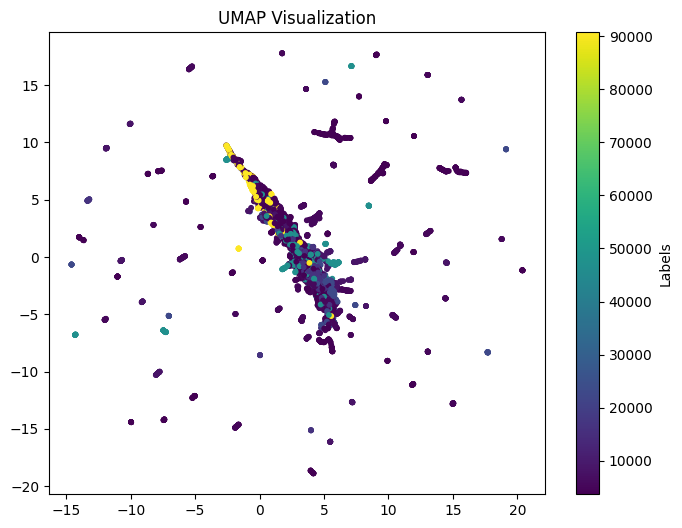

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from Bio import SeqIO

# Load embeddings
embeddings = np.load("/content/embeddings.npy")  # Load your embeddings here

# Load protein sequences and labels
fasta_file = "/content/sequences.fasta"
sequences, labels = load_protein_sequences(fasta_file)

# Create a UMAP model with customizable parameters
umap_model = umap.UMAP(
    n_components=2,  # 2-Dimensional embedding
    n_neighbors=15,  # Adjust this parameter as needed
    min_dist=0.1,    # Adjust this parameter as needed
    metric='euclidean',  # Use a suitable metric
    random_state=42  # Set a random seed for reproducibility
)

# Fit UMAP to the embeddings
umap_embeddings = umap_model.fit_transform(embeddings)

# Create a scatter plot and color points based on labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar(scatter, label='Labels')
plt.title('UMAP Visualization')
plt.savefig('umap_plot.png')  # Save the plot to a file
plt.show()


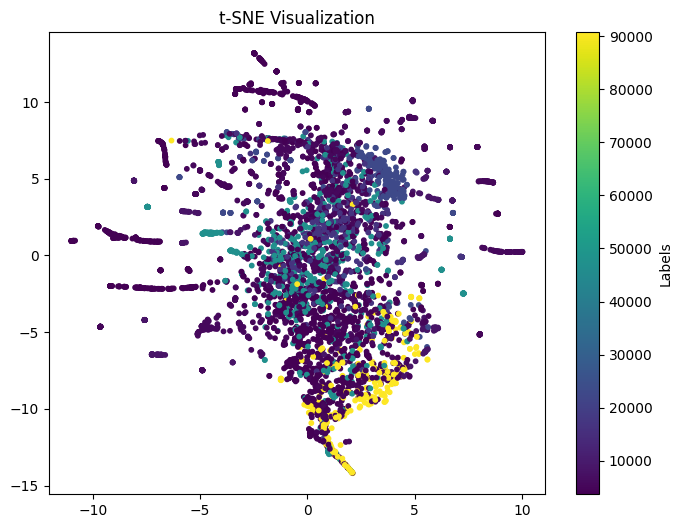

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# Create a t-SNE model with customizable parameters
tsne_model = TSNE(
    n_components=2,  # 2-Dimensional embedding
    perplexity=30,  # Adjust this parameter as needed
    n_iter=300,     # Adjust this parameter as needed
    random_state=42  # Set a random seed for reproducibility
)

# Fit t-SNE to the embeddings
tsne_embeddings = tsne_model.fit_transform(embeddings)

# Create a scatter plot and color points based on labels
plt.figure(figsize=(8, 6))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar(label='Labels')
plt.title('t-SNE Visualization')
plt.savefig('tsne_plot.png')  # Save the plot to a file
plt.show()


In [26]:
!pip install openTSNE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 14.4 MB/s eta 0:00:00


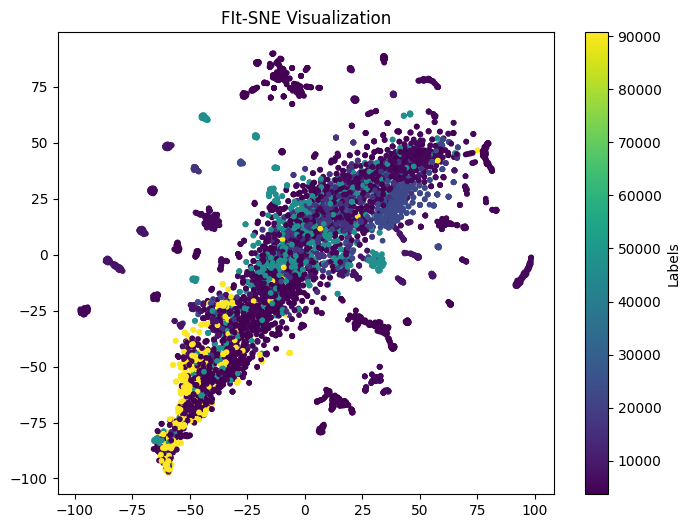

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from openTSNE import TSNE


# Create an FIt-SNE model with customizable parameters
fitsne_model = TSNE(
    n_components=2,              # 2-Dimensional embedding
    early_exaggeration=4,       # Adjust this parameter as needed
    perplexity=30,              # Adjust this parameter as needed
    n_iter=1000,                # Adjust this parameter as needed
    random_state=42             # Set a random seed for reproducibility
)

# Fit FIt-SNE to the embeddings
fitsne_embeddings = fitsne_model.fit(embeddings)

# Create a scatter plot and color points based on labels
plt.figure(figsize=(8, 6))
plt.scatter(fitsne_embeddings[:, 0], fitsne_embeddings[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar(label='Labels')
plt.title('FIt-SNE Visualization')
plt.savefig('fitsne_plot.png')  # Save the plot to a file
plt.show()
